## Практическое задание к уроку 7 по теме "Сверточные нейронные сети для анализа текста".

Взять датасет отзывов за лето (из архива с материалами или предыдущего занятия)  
Обучить conv сеть в двух вариантах:  
1. Инициализировать Embedding предобученными векторами, взять к примеру с https://rusvectores.org/ru/.  
2. Инициализировать слой Embedding по умолчанию (ну то есть ничего не делать с весами)   
Сравнить две архитектуры с предобученными весами и когда Embedding обучается сразу со всей сетью, что получилось лучше.

Загрузим библиотеки и датасет:

In [1]:
%matplotlib inline

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymorphy2 import MorphAnalyzer
from razdel import tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
# from stop_words import get_stop_words
from string import punctuation
import torch
from torch import nn
from torchinfo import summary
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [2]:
df = pd.read_excel('data/отзывы за лето.xls')
print(df.shape)
df.head()

(20659, 3)


,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


Это датасет отзывов пользователей на некое приложение. Пользователи  
помимо текстового сообщения оставляют оценку в диапазоне от 1 до 5.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20659 entries, 0 to 20658
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   20659 non-null  int64 
 1   Content  20656 non-null  object
 2   Date     20659 non-null  object
dtypes: int64(1), object(2)
memory usage: 484.3+ KB


Видим, что некоторые значения отсутствуют, посмотрим на эти строки:

In [4]:
df.loc[df['Content'].isna()]

,Rating,Content,Date
2587,5,NaN,2017-08-10
3533,5,NaN,2017-08-09
9161,4,NaN,2017-08-01


Удалим их, так как отсутствует самый важный столбец:

In [5]:
df.dropna(inplace=True)

Некоторые значения в текстовом столбце по факту являются числами,  
и токенайзеры "ругаются" на это. Сразу переведём все тексты в текстовый  
формат:

In [6]:
df['Content'] = df['Content'].astype(str)

Для справки посмотрим на диапазон дат:

In [7]:
df['Date'].min(), df['Date'].max()

('2017-06-01', '2017-08-14')

В реальной задаче мы бы, скорее всего, использовали атрибут  
дат, так как есть вероятность, что у приложения выходили версии,  
что влияло на отзывы пользователей. Но в нашем задании это не цель,  
мы будем работать исключительно по nlp-части, с текстовым атрибутом.

Посмотрим на распределение оценок:

In [8]:
df['Rating'].value_counts()

5    14584
1     2276
4     2137
3      911
2      748
Name: Rating, dtype: int64

Данную задачу для удобства переведём в задачу бинарной  
классификации, т.к. для нашего задания это не принципиально,  
а также у нас слишком мало примеров для мультиклассовой классификации.

Разберёмся, куда отнести отзывы с оценкой "3":

In [9]:
for text in df.loc[df['Rating'] == 3].head(10)['Content']:
    print(text)

При заходе дважды требует пароль.и на оплате электроэнергии виснет намертво на первом листе списка и висит загрузка вечно (
При рабочем интернете приложение никак не может соединиться с сервером. Исправьте
Медленно
Почему список уведомлений доступен без регистрации и его невозможно очистить? Когда добавите платежи через приложение с помощью NFC? В приложении не видна переписка с банком.
Сделайте возможность помечать все уведомления как прочитанные. Сейчас в списке уведомлений непонятно, какое из них прочитано, а какое нет (т.е. не прочитанные не выделены жирным шрифтом или еще как-то). Значок о непрочитанных уведомлениях висит над иконкой приложения и раздражает.
Глючит на системе андроид. Вход в приложение осуществляется со второго раза. Приходит смс, что вход выполнен, но опять спрашивает пароль. Со второй попытки вход срабатывает. Делаю вывод, что это из-за двухсимочного телефона. На приложении IOS на ipad работает хорошо, но закрыть он-лайн счета в ipad невозможно.
При наличии рут 

Это, субъективно, скорее, негативные отзывы, поэтому причислим  
их к таковым. Также "4" и "5" будем считать позитивными, а "1" и "2" -  
негативными:

In [10]:
df['is_negative'] = df['Rating'].apply(lambda x: 0 if x in (4, 5) else 1)

In [11]:
df.tail()

,Rating,Content,Date,is_negative
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01,1
20655,5,Ок,2017-06-01,0
20656,4,Доволен,2017-06-01,0
20657,1,"Песопаснасть, рут ни нужын",2017-06-01,1
20658,5,Сбербанк бомбовая компания на сегодняшний день...,2017-06-01,0


Посмотрим на распределение получившихся классов:

In [12]:
df['is_negative'].value_counts(normalize=True)

0    0.809498
1    0.190502
Name: is_negative, dtype: float64

Имеем довольно серьёзный дисбаланс классов, поэтому не  
будем пользоваться метрикой accuracy. В процессе обучения  
сетей будем мониторить метрику ROC-AUC, т.к. F1-score будет  
нестабильна из-за вляния значения порога классификации.  
При оценке результатов обучения будем выводить classification  
report и ориентироваться на значения F1-score по классам.

In [13]:
RANDOM_STATE = 29

Сделаем разбивку на трейн/тест:

In [14]:
X_train, X_val, y_train, y_val = train_test_split(df['Content'], df['is_negative'].values,
                                                  test_size=0.2, random_state=RANDOM_STATE)

В качествке предобученных эмбеддингов будем использовать  
эмбеддинги модели BERT. Загрузим её:

In [15]:
model_name = 'bert-base-multilingual-uncased'
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Для выбора длины последовательностей оценим распределение  
длин по датасету:

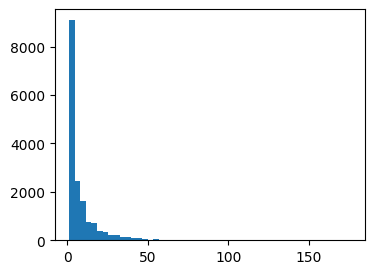

In [16]:
plt.figure(figsize=(4, 3))
plt.hist(X_train.apply(lambda x: len(x.split())), bins=50);

Думаю, что 40 будет неплохим вариантом:

In [17]:
MAX_LEN = 40

Напишем датасет для подготовки даталоадеров. Для предобученных  
эмбеддингов будем использовать соответствующий им токенайзер.  
Для своей модели будем сами производить предобработку:

In [18]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, pretrained=False):
        
        self.pretrained = pretrained
        if self.pretrained:
            self.texts = [tokenizer(text, padding='max_length', max_length=MAX_LEN,
                                truncation=True, return_tensors='pt')
                          for text in texts]
        else:
            self.texts = texts.values
        self.labels = labels
    
    def __getitem__(self, index):
        x = self.texts[index] if self.pretrained else torch.IntTensor(self.texts[index])
        return x, self.labels[index]
    
    def __len__(self):
        return len(self.texts)

Инициализируем даталоадеры:

In [19]:
BATCH_SIZE = 128

In [20]:
torch.random.manual_seed(RANDOM_STATE)

train_dataset = ReviewsDataset(X_train, y_train, pretrained=True)
val_dataset = ReviewsDataset(X_val, y_val, pretrained=True)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

Будем исползовать следующий слой модели BERT:

In [21]:
model.bert.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(105879, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Напишем класс нашей нейросети. Немного громоздко, но поддерживает  
оба варианта: с предобученными эмбеддингами и нет, чтобы не писать  
потом второй раз. Сеть будет довольно простая, с одним свёрточным  
слоем, глобальным макспулингом и одним скрытым полносвязным слоем.

In [22]:
class ConvModel(nn.Module):
    def __init__(self, conv_out=128, pretrained=False, embedding_dim=256, vocab_size=None):
        if not pretrained:
            assert vocab_size is not None, 'Vocabulary size should be given when using non-pretrained model'
        super().__init__()
        self.pretrained = pretrained
        self.embedding_dim = 768 if self.pretrained else embedding_dim
        self.embedding = model.bert.embeddings if self.pretrained else \
                         nn.Embedding(vocab_size, self.embedding_dim, padding_idx=0)
        self.conv = nn.Sequential(nn.Conv1d(self.embedding_dim, out_channels=conv_out, kernel_size=3),
                                  nn.MaxPool1d(MAX_LEN - 2),
                                  nn.ReLU())
        self.fc1 = nn.Sequential(nn.Linear(conv_out, conv_out // 4),
                                 nn.ReLU())
        self.dp = nn.Dropout(0.5)
        self.fc2 = nn.Linear(conv_out // 4, 1)
        
    def forward(self, x):
        x = torch.squeeze(x['input_ids']) if self.pretrained else x
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.fc1(torch.squeeze(x))
        x = self.dp(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x
    
    def predict(self, x):
        if self.pretrained:
            x = tokenizer(x, padding='max_length', max_length=MAX_LEN,
                          truncation=True, return_tensors='pt').to(device)
            x = self.forward(x)
        
        else:
            x = torch.Tensor([self.forward(torch.IntTensor(line)[np.newaxis, :].to(device)) for line in x])
        
        return torch.squeeze((x >= 0.5) * 1)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Посмотрим на число параметров сети, "заморозим" веса  
предобученных эмбеддингов:

In [24]:
net = ConvModel(pretrained=True)
for param in net.embedding.parameters():
    param.requires_grad = False

In [25]:
summary(net)

Layer (type:depth-idx)                   Param #
ConvModel                                --
├─BertEmbeddings: 1-1                    --
│    └─Embedding: 2-1                    (81,315,072)
│    └─Embedding: 2-2                    (393,216)
│    └─Embedding: 2-3                    (1,536)
│    └─LayerNorm: 2-4                    (1,536)
│    └─Dropout: 2-5                      --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-6                       295,040
│    └─MaxPool1d: 2-7                    --
│    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
│    └─Linear: 2-9                       4,128
│    └─ReLU: 2-10                        --
├─Dropout: 1-4                           --
├─Linear: 1-5                            33
Total params: 82,010,561
Trainable params: 299,201
Non-trainable params: 81,711,360

Обучить нужно только 300 тыс. параметров. Напишем функцию для  
обучения сети:

In [26]:
def train_nn(epochs=5, conv_out=128, pretrained=False, vocab_size=None, return_model=False):
    
    torch.random.manual_seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    
    net = ConvModel(conv_out=conv_out, pretrained=pretrained, vocab_size=vocab_size).to(device)
    if pretrained:
        for param in net.embedding.parameters():
            param.requires_grad = False

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        train_losses = np.array([])
        test_losses = np.array([])
        train_metrics = np.array([])
        test_metrics = np.array([])

        for i, (inputs, labels) in enumerate(train_loader):
            net.train()
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()

            train_losses = np.append(train_losses, loss.item())

            net.eval()
            outputs = net(inputs)
            try:
                train_metrics = np.append(train_metrics, roc_auc_score(labels.cpu().detach().numpy(), 
                                                                       outputs.cpu().detach().numpy(), average='weighted'))
            except ValueError:
                pass

        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Loss: {train_losses.mean():.3f}. ' \
              f'ROC-AUC: {train_metrics.mean():.3f}', end='. ')


        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)

                loss = criterion(outputs, labels.float().view(-1, 1))
                test_losses = np.append(test_losses, loss.item())
                try:
                    test_metrics = np.append(test_metrics, roc_auc_score(labels.cpu().detach().numpy(), 
                                                                         outputs.cpu().detach().numpy(), average='weighted'))
                except ValueError:
                    pass

        print(f'Test loss: {test_losses.mean():.3f}. ROC-AUC: {test_metrics.mean():.3f}')

    print('Training is finished!')
    if return_model:
        return net

In [27]:
net = train_nn(epochs=15, pretrained=True, return_model=True)

Epoch [1/15]. Loss: 0.420. ROC-AUC: 0.900. Test loss: 0.302. ROC-AUC: 0.923
Epoch [2/15]. Loss: 0.284. ROC-AUC: 0.937. Test loss: 0.246. ROC-AUC: 0.939
Epoch [3/15]. Loss: 0.250. ROC-AUC: 0.949. Test loss: 0.232. ROC-AUC: 0.943
Epoch [4/15]. Loss: 0.233. ROC-AUC: 0.955. Test loss: 0.224. ROC-AUC: 0.947
Epoch [5/15]. Loss: 0.220. ROC-AUC: 0.959. Test loss: 0.220. ROC-AUC: 0.948
Epoch [6/15]. Loss: 0.207. ROC-AUC: 0.964. Test loss: 0.216. ROC-AUC: 0.950
Epoch [7/15]. Loss: 0.201. ROC-AUC: 0.967. Test loss: 0.213. ROC-AUC: 0.951
Epoch [8/15]. Loss: 0.191. ROC-AUC: 0.970. Test loss: 0.214. ROC-AUC: 0.952
Epoch [9/15]. Loss: 0.181. ROC-AUC: 0.973. Test loss: 0.208. ROC-AUC: 0.954
Epoch [10/15]. Loss: 0.174. ROC-AUC: 0.976. Test loss: 0.207. ROC-AUC: 0.954
Epoch [11/15]. Loss: 0.167. ROC-AUC: 0.979. Test loss: 0.208. ROC-AUC: 0.954
Epoch [12/15]. Loss: 0.159. ROC-AUC: 0.981. Test loss: 0.205. ROC-AUC: 0.954
Epoch [13/15]. Loss: 0.152. ROC-AUC: 0.984. Test loss: 0.207. ROC-AUC: 0.955
Epoch [1

Сделаем предсказание:

In [28]:
pred = net.predict(X_val.tolist())

Напишем функцию для извлечения значений метрик из  
classification report'а:

In [29]:
def get_class_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    report = classification_report(y_true, y_pred, output_dict=True)
    f1_0 = round(report['0']['f1-score'], 3)
    f1_1 = round(report['1']['f1-score'], 3)
    f1_macro = round(report['macro avg']['f1-score'], 3)
    return f1_0, f1_1, f1_macro

Начинам собирать метрики для последующего сведения в таблицу:

In [30]:
names = ['Pretrained embeddings']
pretrained_scores = get_class_report(y_val, pred.cpu())

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3310
           1       0.80      0.75      0.77       822

    accuracy                           0.91      4132
   macro avg       0.87      0.85      0.86      4132
weighted avg       0.91      0.91      0.91      4132



Обучим в качестве бейзлайна модель логистической регрессии  
с tfidf векторайзером. Просто чтобы оценить, какой результат  
покажет модель, которая не требует практически никаких трудовых  
затрат:

In [31]:
vectorizer = TfidfVectorizer()
scaler = MaxAbsScaler()
classifier = LogisticRegression()

lr_model = make_pipeline(vectorizer, scaler, classifier)

In [32]:
lr_model.fit(X_train, y_train);

In [33]:
y_score = lr_model.predict_proba(X_val)[:, 1]
y_pred = lr_model.predict(X_val)

In [34]:
roc_auc_score(y_val, y_score, average='weighted')

0.9519729346300012

In [35]:
names.append('Tfidf + LR Baseline')
baseline = get_class_report(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3310
           1       0.77      0.71      0.74       822

    accuracy                           0.90      4132
   macro avg       0.85      0.83      0.84      4132
weighted avg       0.90      0.90      0.90      4132



Теперь будем обучать нашу модель с обучающимися  
эмбеддингами. Будем проводить фильтрацию пунктуации,  
токенизацию с помощью библиотеки razdel, а также  
лемматизацию с помощью библиотеки pymorphy2.  
Стопслова убирать не будем, так как их использование  
приводило к тому, что некоторые отзывы оказывались пустыми.

In [36]:
lemmatizer = MorphAnalyzer()
# sw = get_stop_words('ru')

In [37]:
def preprocess_text(text):
    text = re.sub(f'[{punctuation}]', ' ', text)
    text = text.lower()
    text = re.sub('не\s+', 'не', text)
    text = tokenize(text)
    text = ' '.join(lemmatizer.parse(token.text)[0].normal_form for token in text)
    # text = ' '.join(token for token in text if token not in sw)
    return text

In [38]:
tqdm.pandas()

X_train_prepared = X_train.progress_apply(preprocess_text)
X_val_prepared = X_val.progress_apply(preprocess_text)

100%|██████████████████████████████████████| 4132/4132 [00:04<00:00, 975.27it/s]


In [39]:
X_train_prepared

18935                                               крутяк
10583                                                класс
2182                                   пока всё устраивать
4352                                  всё работать отлично
17312                                                супер
                               ...                        
10604                                  отличный приложение
864                                            отлично всё
808      на андроид 7 перестать работать писать что сет...
10752                                       всё устраивать
6382     позорище такой кантор а прога создать путевой ...
Name: Content, Length: 16524, dtype: object

Посмотрим теперь на длину текстов:

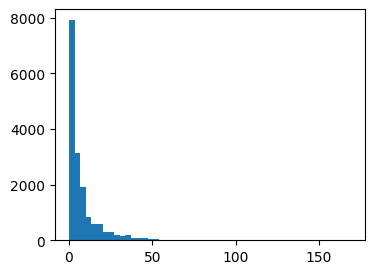

In [40]:
plt.figure(figsize=(4, 3))
plt.hist(X_train_prepared.apply(lambda x: len(x.split())), bins=50);

Значение максимальной длины 40 здесь также хорошо подходит.

Сгенерируем словарь:

In [41]:
corpus = ' '.join(X_train_prepared)

In [42]:
dist = Counter(corpus.split())

In [43]:
vocabulary = {w: i for i, w in dict(enumerate(dist.keys(), 1)).items()}

In [44]:
len(vocabulary)

8766

Довольно небольшая длина словаря, не будем её урезать.

In [45]:
VOCAB_SIZE = len(vocabulary) + 1

Переведём наши тексты в наборы индексов, обрежем или  
добавим паддинг, где необходимо:

In [46]:
def text_to_seq(text):
    seq = []
    for token in text.split():
        if token in vocabulary:
            seq.append(vocabulary[token])
    padding = [0] * (MAX_LEN - len(seq))
    return seq[:MAX_LEN] + padding

In [47]:
X_train_padded = X_train_prepared.apply(text_to_seq)
X_val_padded = X_val_prepared.apply(text_to_seq)

In [48]:
X_train_padded.sample(5)

18216    [1434, 13, 9, 1434, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
10234    [16, 17, 1586, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
12434    [13, 8, 152, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
16318    [1221, 882, 285, 45, 4, 25, 6, 93, 2221, 0, 0,...
15765    [141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
Name: Content, dtype: object

Соберём даталоадеры для обработанных данных:

In [49]:
torch.random.manual_seed(RANDOM_STATE)

train_dataset = ReviewsDataset(X_train_padded, y_train, pretrained=False)
val_dataset = ReviewsDataset(X_val_padded, y_val, pretrained=False)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

Посмотрим на число параметров:

In [50]:
net = ConvModel(vocab_size=VOCAB_SIZE)

In [51]:
summary(net)

Layer (type:depth-idx)                   Param #
ConvModel                                --
├─Embedding: 1-1                         2,244,352
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       98,432
│    └─MaxPool1d: 2-2                    --
│    └─ReLU: 2-3                         --
├─Sequential: 1-3                        --
│    └─Linear: 2-4                       4,128
│    └─ReLU: 2-5                         --
├─Dropout: 1-4                           --
├─Linear: 1-5                            33
Total params: 2,346,945
Trainable params: 2,346,945
Non-trainable params: 0

Обучим модель:

In [52]:
net = train_nn(epochs=15, vocab_size=VOCAB_SIZE, return_model=True)

Epoch [1/15]. Loss: 0.563. ROC-AUC: 0.561. Test loss: 0.457. ROC-AUC: 0.732
Epoch [2/15]. Loss: 0.393. ROC-AUC: 0.853. Test loss: 0.347. ROC-AUC: 0.879
Epoch [3/15]. Loss: 0.314. ROC-AUC: 0.919. Test loss: 0.297. ROC-AUC: 0.915
Epoch [4/15]. Loss: 0.270. ROC-AUC: 0.942. Test loss: 0.273. ROC-AUC: 0.924
Epoch [5/15]. Loss: 0.242. ROC-AUC: 0.952. Test loss: 0.258. ROC-AUC: 0.932
Epoch [6/15]. Loss: 0.223. ROC-AUC: 0.960. Test loss: 0.250. ROC-AUC: 0.935
Epoch [7/15]. Loss: 0.207. ROC-AUC: 0.965. Test loss: 0.244. ROC-AUC: 0.937
Epoch [8/15]. Loss: 0.193. ROC-AUC: 0.970. Test loss: 0.242. ROC-AUC: 0.939
Epoch [9/15]. Loss: 0.180. ROC-AUC: 0.974. Test loss: 0.240. ROC-AUC: 0.939
Epoch [10/15]. Loss: 0.169. ROC-AUC: 0.978. Test loss: 0.236. ROC-AUC: 0.941
Epoch [11/15]. Loss: 0.156. ROC-AUC: 0.981. Test loss: 0.240. ROC-AUC: 0.941
Epoch [12/15]. Loss: 0.146. ROC-AUC: 0.984. Test loss: 0.239. ROC-AUC: 0.942
Epoch [13/15]. Loss: 0.134. ROC-AUC: 0.986. Test loss: 0.239. ROC-AUC: 0.943
Epoch [1

In [53]:
pred = net.predict(X_val_padded)

In [54]:
names.append('Non-pretrained embeddings')
nonpretrained = get_class_report(y_val, pred.cpu())

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3310
           1       0.76      0.74      0.75       822

    accuracy                           0.90      4132
   macro avg       0.85      0.84      0.84      4132
weighted avg       0.90      0.90      0.90      4132



Теперь, для интереса, обучим тот же бейзлайн с логистической  
регрессией, но когда векторайзер работает с n-граммами символов.  
Много орфографических ошибок в отзывах, а также общая довольно  
малая длина датасета подталкивает к такому подходу:

In [55]:
vectorizer = TfidfVectorizer(ngram_range=(2, 5), analyzer='char')
scaler = MaxAbsScaler()
classifier = LogisticRegression()

lr_model = make_pipeline(vectorizer, scaler, classifier)

In [56]:
lr_model.fit(X_train, y_train);

In [57]:
y_score = lr_model.predict_proba(X_val)[:, 1]
y_pred = lr_model.predict(X_val)

In [58]:
names.append('Char Tfidf + LR')
char_baseline = get_class_report(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3310
           1       0.79      0.74      0.77       822

    accuracy                           0.91      4132
   macro avg       0.86      0.85      0.86      4132
weighted avg       0.91      0.91      0.91      4132



Сведём все результаты в таблицу:

In [59]:
pd.DataFrame([pretrained_scores, baseline, nonpretrained, char_baseline],
             index=names,
             columns=['F1-score 0', 'F1-score 1', 'F1-score macro']).sort_values('F1-score macro', ascending=False)

,F1-score 0,F1-score 1,F1-score macro
Pretrained embeddings,0.946,0.774,0.860
Char Tfidf + LR,0.944,0.767,0.856
Non-pretrained embeddings,0.939,0.749,0.844
Tfidf + LR Baseline,0.938,0.738,0.838


Лучше всего показала себя модель свёрточной сети с предобученными  
эмбеддингами. Модель, где эмбеддинги обучались, оказалась, всё-таки,  
хуже. Но это, вероятно, связано с качеством предобработки текста.  
Можно было потратить ещё время на более доскональное изучение датасета  
и подстроить предобработку соответствующим образом. В датасете объективно  
мало примеров для качественного обучения эмбеддингов. Интересно, что  
модель логистической регрессии, где векторайзер обучался на n-граммах  
символов, почти дотянулась до модели с предобученными эмбеддингами.  
При этом не потребовалось никакой предобработки и написания длинного кода  
обучения.